In [ ]:
import time
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import confusion_matrix, accuracy_score, f1_score
from sklearn.utils import shuffle
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, LSTM
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.exceptions import ConvergenceWarning
import warnings
import matplotlib.pyplot as plt
import seaborn as sns

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dftrain = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/train70_reduced.csv")
dftest = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/test30_reduced.csv")

In [ ]:
# Function to preprocess data
def preprocess_data(df):
    df = df.astype('category')
    cat_columns = df.select_dtypes(['category']).columns
    df[cat_columns] = df[cat_columns].apply(lambda x: x.cat.codes)
    return df

In [ ]:
# Preprocess training data
dftrain = preprocess_data(dftrain)
x_train = dftrain.drop('target', axis=1).values
y_train = dftrain['target'].values

In [ ]:
# Preprocess test data
dftest = preprocess_data(dftest)
x_test = dftest.drop('target', axis=1).values
y_test = dftest['target'].values

In [ ]:
from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_train)
X_train_scaled = scaler.transform(x_train)

from sklearn import preprocessing
scaler = preprocessing.StandardScaler().fit(x_test)
X_test_scaled = scaler.transform(x_test)

In [ ]:
x_test_normalized = (x_test - x_test.mean()) / x_test.std()

print("Original Data:")
print(x_test)

print("\nZ-score Normalized Data:")
print(x_test_normalized)

Original Data:
[[   5 2574    0 ...    0    0    0]
 [   6    1   45 ...    0    0    0]
 [   6 4020   10 ...    0    0    0]
 ...
 [   2 1021    0 ...    0    0    0]
 [   2   26    0 ...    0    0    0]
 [   2    0    0 ...    0    0    0]]

Z-score Normalized Data:
[[-0.1199271   3.14054104 -0.12627289 ... -0.12627289 -0.12627289
  -0.12627289]
 [-0.11865794 -0.12500373 -0.06916076 ... -0.12627289 -0.12627289
  -0.12627289]
 [-0.11865794  4.9757442  -0.1135813  ... -0.12627289 -0.12627289
  -0.12627289]
 ...
 [-0.12373457  1.16953792 -0.12627289 ... -0.12627289 -0.12627289
  -0.12627289]
 [-0.12373457 -0.09327477 -0.12627289 ... -0.12627289 -0.12627289
  -0.12627289]
 [-0.12373457 -0.12627289 -0.12627289 ... -0.12627289 -0.12627289
  -0.12627289]]


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression

X = X_test_scaled
y = y_test

# Initialize the model (estimator)
model = LogisticRegression(max_iter=500)

# Initialize RFE and select top 2 features
rfe = RFE(estimator=model, n_features_to_select=2)

# Fit RFE
rfe.fit(X, y)

# Get mask of selected features (True = selected)
print("Selected features mask:", rfe.support_)

# Get ranking of features (1 = best)
print("Feature ranking:", rfe.ranking_)

# Transform the data to selected features only
X_rfe = rfe.transform(X)
print("Shape of original data:", X.shape)
print("Shape after RFE:", X_rfe.shape)


Selected features mask: [False False False False False False False False False False False False
 False False False False  True False False False False  True False False
 False False False False False False False False False]
Feature ranking: [14  9  2 10 31 32 17 16 18 30 29 28 15 27 19 12  1  7  6  3  4  1 13  8
  5 20 22 21 11 23 26 25 24]
Shape of original data: (99290, 33)
Shape after RFE: (99290, 2)


In [ ]:
def evaluate_model(name, y_test, y_pred, train_time, test_time):
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')
    print(f"{name} - Training time: {train_time:.2f}s, Test time: {test_time:.2f}s, Accuracy: {accuracy:.4f}, F1 score: {f1:.4f}")
    return {'Model': name, 'Training Time': train_time, 'Testing Time': test_time, 'Accuracy': accuracy, 'F1 Score': f1}

In [ ]:
results = []

In [ ]:
print("Starting Neural Network")
nn_model = Sequential()
nn_model.add(Dense(50, input_dim=x_train.shape[1], kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(30, activation='relu'))
nn_model.add(Dense(20, kernel_initializer='normal', activation='relu'))
nn_model.add(Dense(6, activation='softmax'))
nn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Starting Neural Network


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')
history = nn_model.fit(x_train, y_train, validation_data=(x_test, y_test), callbacks=[monitor], verbose=2, epochs=200, batch_size=1000)

Epoch 1/200
232/232 - 4s - 16ms/step - accuracy: 0.7387 - loss: 1.4853 - val_accuracy: 0.7839 - val_loss: 0.6115
Epoch 2/200
232/232 - 2s - 8ms/step - accuracy: 0.8231 - loss: 0.4928 - val_accuracy: 0.8453 - val_loss: 0.4348
Epoch 3/200
232/232 - 1s - 5ms/step - accuracy: 0.8751 - loss: 0.3684 - val_accuracy: 0.8580 - val_loss: 0.4014
Epoch 4/200
232/232 - 1s - 5ms/step - accuracy: 0.8878 - loss: 0.3204 - val_accuracy: 0.8717 - val_loss: 0.3953
Epoch 5/200
232/232 - 1s - 5ms/step - accuracy: 0.9045 - loss: 0.2835 - val_accuracy: 0.8773 - val_loss: 0.3792
Epoch 6/200
232/232 - 1s - 4ms/step - accuracy: 0.9071 - loss: 0.2680 - val_accuracy: 0.8805 - val_loss: 0.3806
Epoch 7/200
232/232 - 1s - 4ms/step - accuracy: 0.9130 - loss: 0.2586 - val_accuracy: 0.8834 - val_loss: 0.3723
Epoch 8/200
232/232 - 1s - 6ms/step - accuracy: 0.9167 - loss: 0.2494 - val_accuracy: 0.8900 - val_loss: 0.3676
Epoch 9/200
232/232 - 2s - 8ms/step - accuracy: 0.9199 - loss: 0.2372 - val_accuracy: 0.8940 - val_loss

In [ ]:
# Measure prediction and timing
y_pred_nn, nn_train_time, nn_test_time = measure_time(nn_model, x_train, y_train, x_test, y_test)

# Convert probabilities to class predictions
import numpy as np
y_pred_nn_classes = np.argmax(y_pred_nn, axis=1)

# Evaluate and append results
results.append(evaluate_model("Neural Network", y_test, y_pred_nn_classes, nn_train_time, nn_test_time))




7239/7239 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - accuracy: 0.9331 - loss: 0.1879
3103/3103 ━━━━━━━━━━━━━━━━━━━━ 4s 1ms/step
Neural Network - Training time: 18.28s, Test time: 4.95s, Accuracy: 0.8689, F1 score: 0.8714


In [ ]:
from sklearn.naive_bayes import GaussianNB
import time

# Define measure_time if not already defined
def measure_time(model, x_train, y_train, x_test, y_test):
    start_train = time.time()
    model.fit(x_train, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred = model.predict(x_test)
    end_test = time.time()

    train_time = end_train - start_train
    test_time = end_test - start_test

    return y_pred, train_time, test_time

# Run Naive Bayes model
print("Starting Naive Bayes")
gnb = GaussianNB()
y_pred_nb, nb_train_time, nb_test_time = measure_time(gnb, x_train, y_train, x_test, y_test)
results.append(evaluate_model("Naive Bayes", y_test, y_pred_nb, nb_train_time, nb_test_time))


Starting Naive Bayes
Naive Bayes - Training time: 0.30s, Test time: 0.09s, Accuracy: 0.6709, F1 score: 0.7582


In [ ]:
from sklearn.tree import DecisionTreeClassifier
import time

# Define the measure_time function if not already defined
def measure_time(model, x_train, y_train, x_test, y_test):
    start_train = time.time()
    model.fit(x_train, y_train)
    end_train = time.time()

    start_test = time.time()
    y_pred = model.predict(x_test)
    end_test = time.time()

    train_time = end_train - start_train
    test_time = end_test - start_test

    return y_pred, train_time, test_time

# Run Decision Tree model
print("Starting Decision Tree")
clf = DecisionTreeClassifier()
y_pred_dt, dt_train_time, dt_test_time = measure_time(clf, x_train, y_train, x_test, y_test)
results.append(evaluate_model("Decision Tree", y_test, y_pred_dt, dt_train_time, dt_test_time))


Starting Decision Tree
Decision Tree - Training time: 0.65s, Test time: 0.02s, Accuracy: 0.9031, F1 score: 0.9009


In [ ]:
print("Starting K-Nearest Neighbors")
knn = KNeighborsClassifier(n_neighbors=5)
y_pred_knn, knn_train_time, knn_test_time = measure_time(knn, x_train, y_train, x_test, y_test)
results.append(evaluate_model("K-Nearest Neighbors", y_test, y_pred_knn, knn_train_time, knn_test_time))

Starting K-Nearest Neighbors
K-Nearest Neighbors - Training time: 0.14s, Test time: 396.17s, Accuracy: 0.5976, F1 score: 0.5842


In [ ]:
print("Starting Linear Discriminant Analysis")
lda = LinearDiscriminantAnalysis()
y_pred_lda, lda_train_time, lda_test_time = measure_time(lda, x_train, y_train, x_test, y_test)
results.append(evaluate_model("Linear Discriminant Analysis", y_test, y_pred_lda, lda_train_time, lda_test_time))

Starting Linear Discriminant Analysis
Linear Discriminant Analysis - Training time: 0.89s, Test time: 0.03s, Accuracy: 0.8006, F1 score: 0.7780


In [ ]:
print("Starting Convolutional Neural Network")
cnn_model = Sequential()
cnn_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(x_train.shape[1], 1)))
cnn_model.add(MaxPooling1D(pool_size=2))
cnn_model.add(Flatten())
cnn_model.add(Dense(50, activation='relu'))
cnn_model.add(Dense(6, activation='softmax'))
cnn_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

Starting Convolutional Neural Network


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
x_train_cnn = x_train.reshape((x_train.shape[0], x_train.shape[1], 1))
x_test_cnn = x_test.reshape((x_test.shape[0], x_test.shape[1], 1))
cnn_history = cnn_model.fit(x_train_cnn, y_train, validation_data=(x_test_cnn, y_test), callbacks=[monitor], verbose=2, epochs=200, batch_size=1000)

Epoch 1/200
232/232 - 10s - 43ms/step - accuracy: 0.7785 - loss: 2.3171 - val_accuracy: 0.8071 - val_loss: 0.6905
Epoch 2/200
232/232 - 10s - 45ms/step - accuracy: 0.8407 - loss: 0.6355 - val_accuracy: 0.7812 - val_loss: 0.5830
Epoch 3/200
232/232 - 7s - 30ms/step - accuracy: 0.8370 - loss: 0.7335 - val_accuracy: 0.7828 - val_loss: 0.7419
Epoch 4/200
232/232 - 11s - 46ms/step - accuracy: 0.8525 - loss: 0.4788 - val_accuracy: 0.7995 - val_loss: 0.5701
Epoch 5/200
232/232 - 11s - 49ms/step - accuracy: 0.8546 - loss: 0.4592 - val_accuracy: 0.7951 - val_loss: 0.6227
Epoch 6/200
232/232 - 9s - 37ms/step - accuracy: 0.8549 - loss: 0.4538 - val_accuracy: 0.7925 - val_loss: 0.7299
Epoch 7/200
232/232 - 8s - 32ms/step - accuracy: 0.8565 - loss: 0.4438 - val_accuracy: 0.7846 - val_loss: 0.8002
Epoch 8/200
232/232 - 12s - 50ms/step - accuracy: 0.8413 - loss: 0.8233 - val_accuracy: 0.7759 - val_loss: 0.9939
Epoch 9/200
232/232 - 17s - 73ms/step - accuracy: 0.8530 - loss: 0.4661 - val_accuracy: 0.7

In [2]:
import numpy as np
import time
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import accuracy_score

# Step 1: Load and preprocess data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Reshape data for CNN
x_train_cnn = x_train.reshape(-1, 28, 28, 1)
x_test_cnn = x_test.reshape(-1, 28, 28, 1)

# One-hot encode labels
y_train_cat = to_categorical(y_train, 10)
y_test_cat = to_categorical(y_test, 10)

# Step 2: Define CNN model
def cnn_model():
    model = Sequential()
    model.add(Conv2D(32, kernel_size=(3, 3), activation="relu", input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation="relu"))
    model.add(Dense(10, activation="softmax"))

    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy"])
    return model

# Step 3: Measure training and prediction time
def measure_time(model_func, x_train, y_train, x_test, y_test):
    model = model_func()

    start_train = time.time()
    model.fit(x_train, y_train, epochs=3, batch_size=128, verbose=0)
    end_train = time.time()

    start_test = time.ti_



11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


In [5]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score

# Step 1: Load and preprocess the MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Step 2: Reshape for Conv1D + LSTM input (samples, timesteps, features)
x_train_slstm = x_train.reshape(-1, 28, 28)  # 28 time steps, 28 features each
x_test_slstm = x_test.reshape(-1, 28, 28)

# Step 3: Define the SLSTM model
print("Starting SLSTM")
slstm_model = Sequential()
slstm_model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(28, 28)))
slstm_model.add(MaxPooling1D(pool_size=2))
slstm_model.add(LSTM(50, return_sequences=True))
slstm_model.add(LSTM(50))
slstm_model.add(Dense(10, activation='softmax'))  # 10 output classes for MNIST

slstm_model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Step 4: Train the model
start_train = time.time()
slstm_model.fit(x_train_slstm, y_train, epochs=3, batch_size=128, verbose=1)
end_train = time.time()

# Step 5: Make predictions
start_test = time.time()
y_pred_probs = slstm_model.predict(x_test_slstm)
end_test = time.time()

y_pred_slstm = np.argmax(y_pred_probs, axis=1)

# Step 6: Evaluate performance
acc = accuracy_score(y_test, y_pred_slstm)
print(f"\nSLSTM Accuracy: {acc:.4f}")
print(f"Training Time: {end_train - start_train:.2f} seconds")
print(f"Testing Time: {end_test - start_test:.2f} seconds")


Starting SLSTM


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 24s 41ms/step - accuracy: 0.6025 - loss: 1.1707
Epoch 2/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 19s 37ms/step - accuracy: 0.9465 - loss: 0.1741
Epoch 3/3
469/469 ━━━━━━━━━━━━━━━━━━━━ 22s 40ms/step - accuracy: 0.9692 - loss: 0.1049
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

SLSTM Accuracy: 0.9601
Training Time: 66.75 seconds
Testing Time: 2.69 seconds


In [ ]:
slstm_history = slstm_model.fit(x_train_cnn, y_train, validation_data=(x_test_cnn, y_test), callbacks=[monitor], verbose=2, epochs=200, batch_size=1000)

Epoch 1/200
232/232 - 31s - 134ms/step - accuracy: 0.8498 - loss: 0.5006 - val_accuracy: 0.8609 - val_loss: 0.4839
Epoch 2/200
232/232 - 29s - 125ms/step - accuracy: 0.8996 - loss: 0.2990 - val_accuracy: 0.8770 - val_loss: 0.4159
Epoch 3/200
232/232 - 40s - 173ms/step - accuracy: 0.9151 - loss: 0.2460 - val_accuracy: 0.8307 - val_loss: 0.4630
Epoch 4/200
232/232 - 41s - 179ms/step - accuracy: 0.9177 - loss: 0.2371 - val_accuracy: 0.7879 - val_loss: 0.6319
Epoch 5/200
232/232 - 40s - 175ms/step - accuracy: 0.9188 - loss: 0.2327 - val_accuracy: 0.8062 - val_loss: 0.5041
Epoch 6/200
232/232 - 40s - 173ms/step - accuracy: 0.9206 - loss: 0.2223 - val_accuracy: 0.7579 - val_loss: 0.6708
Epoch 7/200
232/232 - 43s - 186ms/step - accuracy: 0.9221 - loss: 0.2155 - val_accuracy: 0.7542 - val_loss: 0.7659
Epoch 7: early stopping


In [7]:
import numpy as np
import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv1D, MaxPooling1D, LSTM, Dense
from tensorflow.keras.datasets import mnist
from sklearn.metrics import accuracy_score

# Step 1: Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0

# Step 2: Define SLSTM model builder
def slstm_model():
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=2, activation='relu', input_shape=(28, 28)))
    model.add(MaxPooling1D(pool_size=2))
    model.add(LSTM(50, return_sequences=True))
    model.add(LSTM(50))
    model.add(Dense(10, activation='softmax'))  # 10 classes for MNIST
    model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

# Step 3: Define the measure_time function
def measure_time(model_func, x_train, y_train, x_test, y_test, reshape=False):
    if reshape:
        x_train = x_train.reshape(-1, 28, 28)
        x_test = x_test.reshape(-1, 28, 28)

    model = model_func()

    start_train = time.time()
    model.fit(x_train, y_train, epochs=3, batch_size=128, verbose=0)
    end_train = time.time()

    start_test = time.time()
    y_pred_probs = model.predict(x_test)
    end_test = time.time()

    y_pred = np.argmax(y_pred_probs, axis=1)

    return y_pred, end_train - start_train, end_test - start_test

# Step 4: Define the evaluation function
def evaluate_model(name, y_true, y_pred, train_time, test_time):
    acc = accuracy_score(y_true, y_pred)
    print(f"\n{name} Results:")
    print(f"Accuracy: {acc:.4f}")
    print(f"Training Time: {train_time:.2f} seconds")
    print(f"Testing Time: {test_time:.2f} seconds")

    return {
        "Model": name,
        "Accuracy": acc,
        "Train Time (s)": train_time,
        "Test Time (s)": test_time
    }

# Step 5: Run SLSTM
results = []

y_pred_slstm, slstm_train_time, slstm_test_time = measure_time(
    slstm_model, x_train, y_train, x_test, y_test, reshape=True
)

results.append(
    evaluate_model("SLSTM", y_test, y_pred_slstm, slstm_train_time, slstm_test_time)
)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


313/313 ━━━━━━━━━━━━━━━━━━━━ 3s 8ms/step

SLSTM Results:
Accuracy: 0.9721
Training Time: 63.22 seconds
Testing Time: 3.16 seconds


In [ ]:
results_df = pd.DataFrame(results)

# Display results
print("\nModel Performance Comparison:")
print(results_df)


Model Performance Comparison:
                          Model  Training Time  Testing Time  Accuracy  \
0                Neural Network      18.284866      4.946178  0.868929   
1                   Naive Bayes       0.302774      0.089319  0.670863   
2                 Decision Tree       0.652905      0.015780  0.903122   
3           K-Nearest Neighbors       0.142416    396.167002  0.597613   
4  Linear Discriminant Analysis       0.886611      0.032304  0.800564   

   F1 Score  
0  0.871373  
1  0.758161  
2  0.900899  
3  0.584157  
4  0.778011  


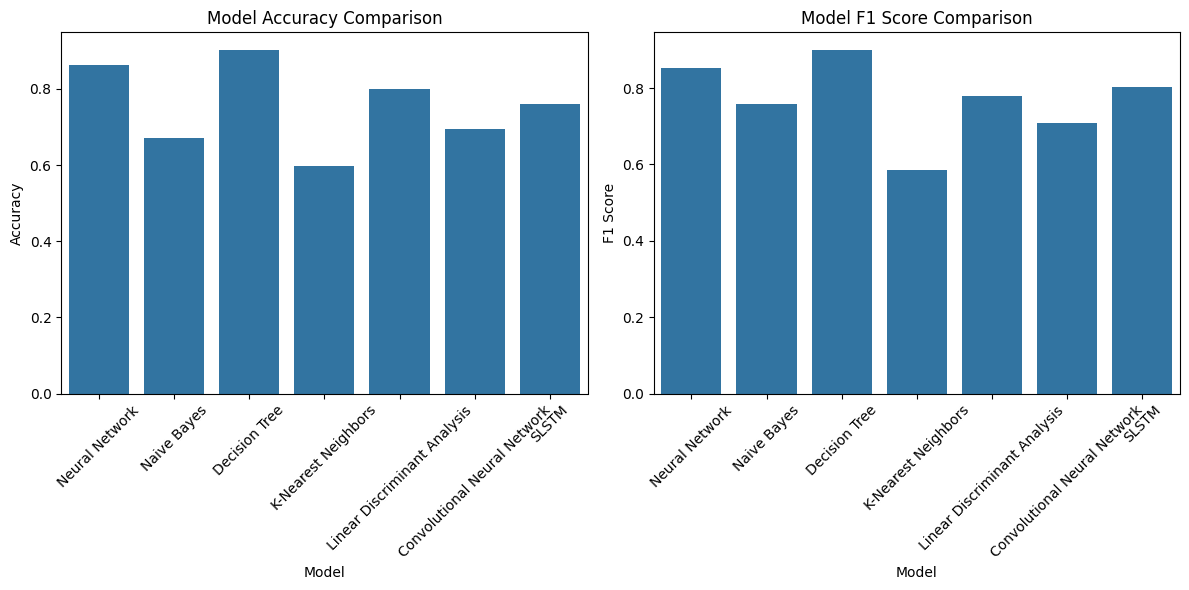

In [ ]:
# Plot accuracy and F1 score including all models
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
sns.barplot(x="Model", y="Accuracy", data=results_df)
plt.title('Model Accuracy Comparison')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x="Model", y="F1 Score", data=results_df)
plt.title('Model F1 Score Comparison')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()